In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configurazione grafici
sns.set(style="whitegrid")
%matplotlib inline

In [6]:
# Caricamento Dataset
df = pd.read_csv('../data/youtube_recommendation_dataset -.csv') # Assicurati che il percorso sia giusto

# Data Cleaning & Preprocessing
# Convertiamo le date
df['published_at'] = pd.to_datetime(df['published_at'])

# Encoding variabili categoriche (True/False -> 1/0)
le = LabelEncoder()
df['caption'] = le.fit_transform(df['caption']) 
df['definition'] = le.fit_transform(df['definition']) # hd -> 1, sd -> 0

# Rimozione colonne non utili per la predizione numerica
# 'duration' è ridondante perché abbiamo 'duration_seconds'
drop_cols = ['Title', 'channel_title', 'published_at', 'duration']
df_clean = df.drop(columns=drop_cols)

# Verifica
print(f"Dataset Shape: {df_clean.shape}")
df_clean.head()

Dataset Shape: (537, 12)


,category_id,view_count,like_count,comment_count,favorite_count,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
0,10,1405647,140463,9063,0,0,0,0.106375,0.099928,0.006448,111,1
1,24,2776847,26801,6684,0,0,1,0.012059,0.009652,0.002407,60,0
2,20,1189857,16174,1827,0,0,0,0.015129,0.013593,0.001535,1082,0
3,10,5319161,0,12869,0,0,1,0.002419,0.000000,0.002419,203,1
4,20,597542,41742,4728,0,0,1,0.077768,0.069856,0.007912,215,0


In [7]:
# Creiamo una variabile target: "is_successful"
# Se l'engagement rate è sopra la mediana -> 1 (Successo), altrimenti 0 (Normale/Flop)
threshold = df_clean['engagement_rate'].median()
df_clean['is_successful'] = (df_clean['engagement_rate'] > threshold).astype(int)

print(f"Soglia Engagement Rate: {threshold}")
print("Distribuzione Target:")
print(df_clean['is_successful'].value_counts(normalize=True))

Soglia Engagement Rate: 0.02436755958
Distribuzione Target:
is_successful
0    0.500931
1    0.499069
Name: proportion, dtype: float64


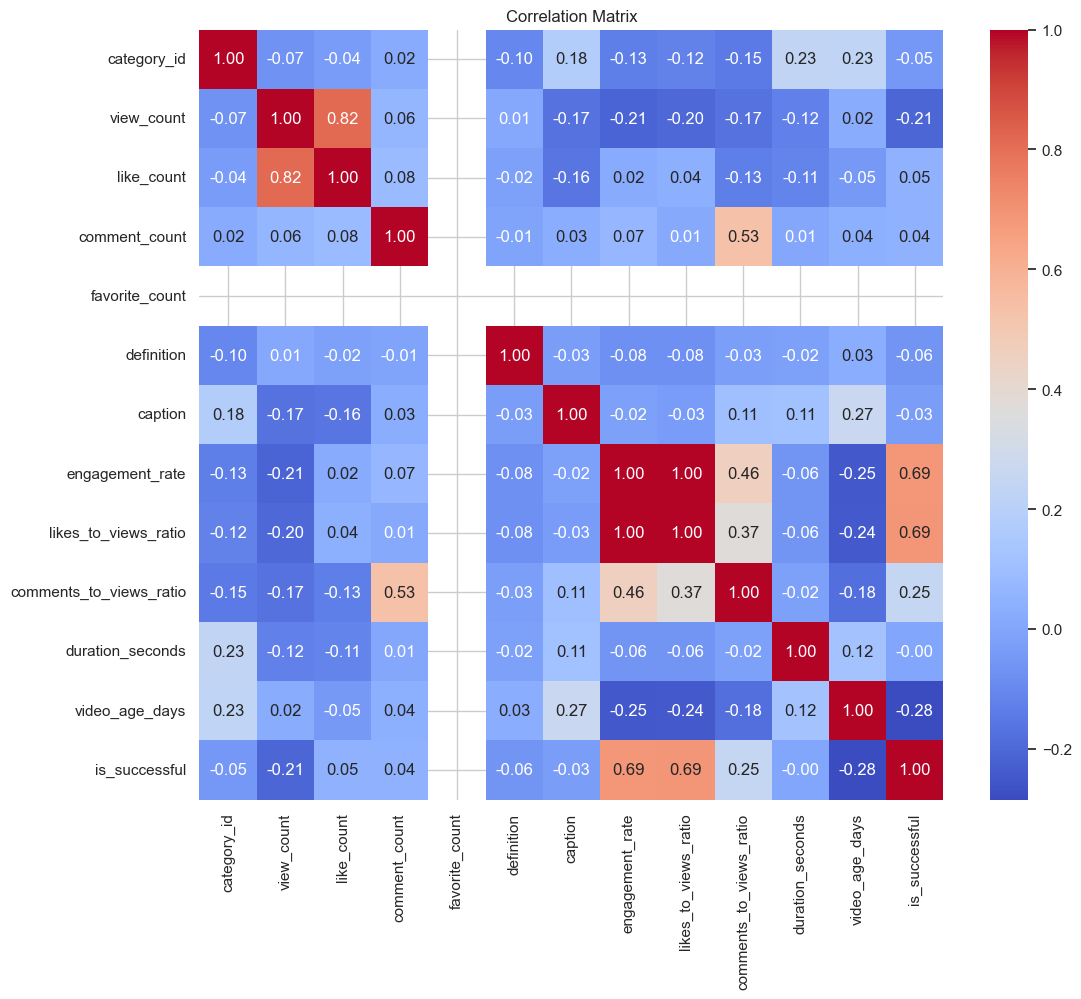

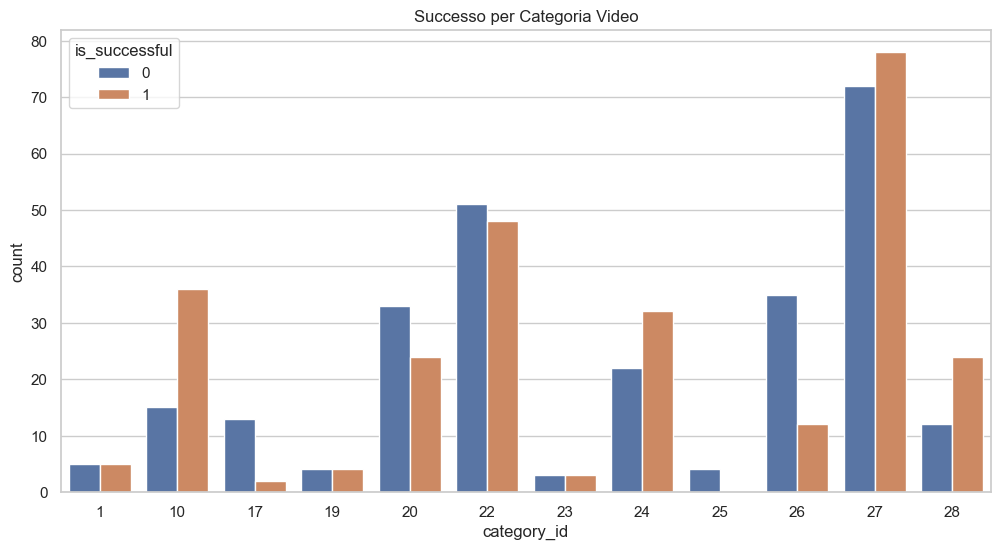

In [8]:
# Matrice di Correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Visualizzazione Distribuzione Successo per Categoria
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='category_id', hue=df_clean['is_successful'])
plt.title('Successo per Categoria Video')
plt.show()

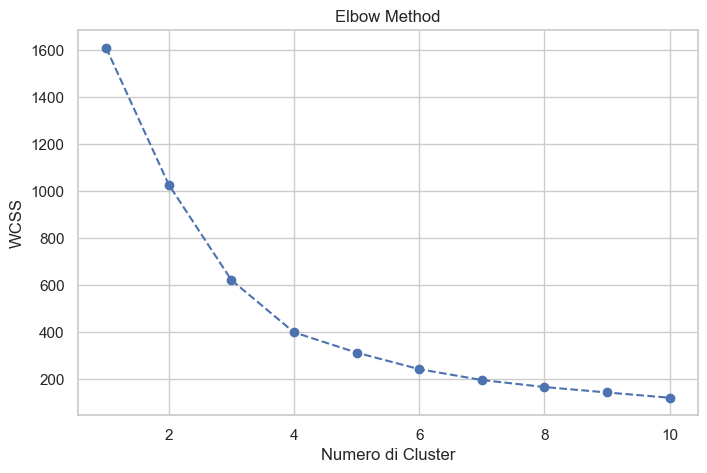

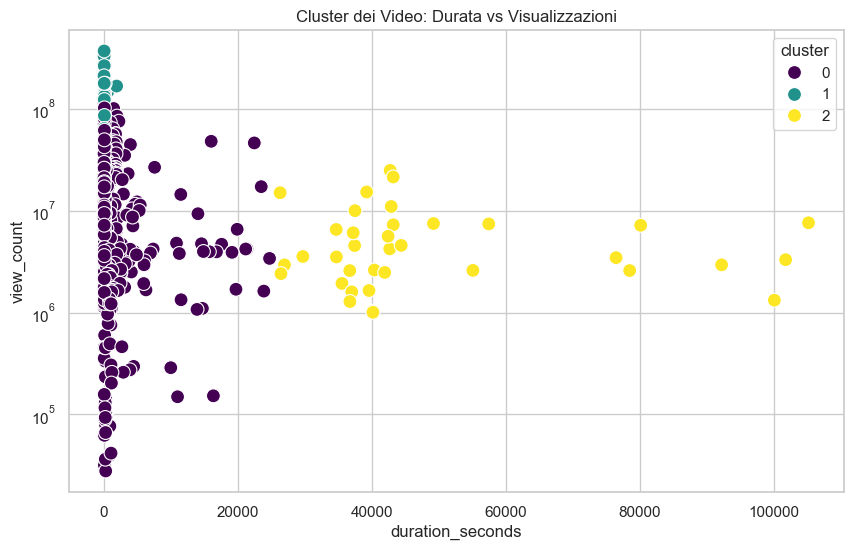

In [9]:
# Selezioniamo feature per il clustering
X_cluster = df_clean[['view_count', 'duration_seconds', 'like_count']]

# Scaling dei dati (fondamentale per K-Means)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Elbow Method per trovare il numero ottimale di cluster
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Numero di Cluster')
plt.ylabel('WCSS')
plt.show()

# Applicazione K-Means con k=3 (scelto dal grafico sopra)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
df_clean['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Visualizzazione Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='duration_seconds', y='view_count', hue='cluster', palette='viridis', s=100)
plt.title('Cluster dei Video: Durata vs Visualizzazioni')
plt.yscale('log') # Scala logaritmica per vedere meglio i dati sparsi
plt.show()

In [10]:
# Definizione Feature (X) e Target (y)
# Rimuoviamo le colonne derivate direttamente dalla target (data leakage)
X = df_clean.drop(columns=['is_successful', 'engagement_rate', 'cluster', 'likes_to_views_ratio', 'comments_to_views_ratio'])
y = df_clean['is_successful']

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train)
X_test_scaled = scaler_model.transform(X_test)

# Addestramento
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predizione
y_pred = model.predict(X_test_scaled)

# Valutazione
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.8333333333333334

Confusion Matrix:
 [[44 13]
 [ 5 46]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83        57
           1       0.78      0.90      0.84        51

    accuracy                           0.83       108
   macro avg       0.84      0.84      0.83       108
weighted avg       0.84      0.83      0.83       108



C:\Users\Rei Mici\AppData\Local\Temp\ipykernel_3196\2283730787.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='coefficient', y='feature', palette='viridis')


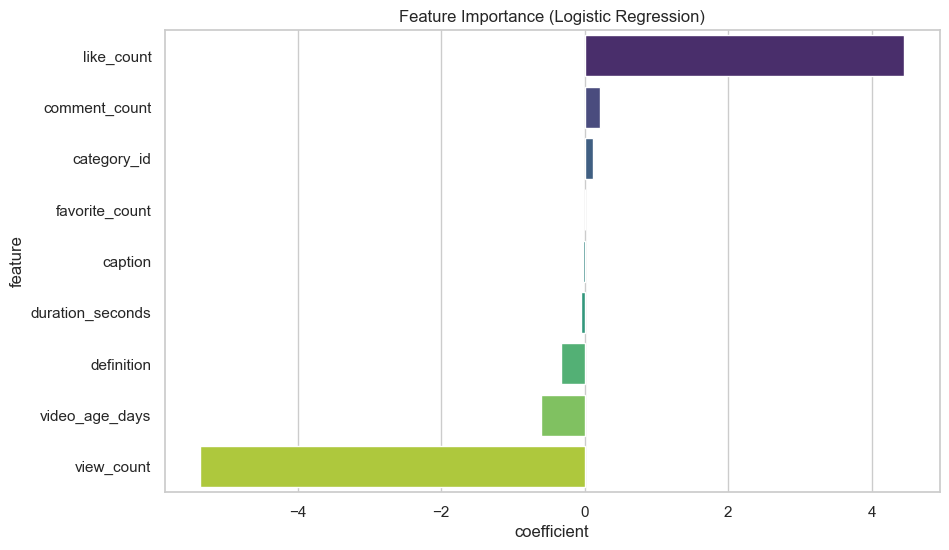

In [11]:
# Quali variabili influenzano di più il successo?
importance = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_[0]})
importance = importance.sort_values(by='coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='coefficient', y='feature', palette='viridis')
plt.title('Feature Importance (Logistic Regression)')
plt.show()